# Prepare Compass inputs, random groups within cell states

Try to capture biological and technical variation by partitioning within replicates divided by age bin, cell/nuclei, cell state

## Setup

In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import sctk
import milopy
import milopy.core as milo

In [19]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'Reds', figsize = (5, 5),dpi_save=300)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [20]:
# Perform pseudobulk on sc data

import scipy.sparse as sp

def pseudo_bulk(
        adata, groupby, use_rep='X', highly_variable=False, FUN=np.mean):
    """Make pseudo bulk data from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    if highly_variable:
        if isinstance(highly_variable, (list, tuple)):
            if use_rep == 'raw':
                k_hv = adata.raw.var_names.isin(highly_variable)
            else:
                k_hv = adata.var_names.isin(highly_variable)
        else:
            k_hv = adata.var['highly_variable'].values
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep == 'raw':
        x = adata.raw.X
        features = adata.raw.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        if sp.issparse(x):
            summarised[i] = FUN(x[k_grp, :], axis=0)
        else:
            summarised[i] = FUN(x[k_grp, :], axis=0, keepdims=True)
    return pd.DataFrame(summarised.T, columns=groups, index=features)

def random_partition(
    adata,
    partition_size,
    groupby=None,
    method="random_even",
    key_added="partition_labels",
    random_state=0,
):
    np.random.seed(random_state)
    if groupby:
        if groupby not in adata.obs.columns:
            raise KeyError(f"{groupby} is not a valid obs annotation.")
        groups = adata.obs[groupby].unique()
        label_df = adata.obs[[groupby]].astype(str).rename(columns={groupby: key_added})
        for grp in groups:
            k = adata.obs[groupby] == grp
            grp_size = sum(k)
            n_partition = max(np.round(grp_size / partition_size).astype(int), 1)
            if method == "random":
                part_idx = np.random.randint(low=0, high=n_partition, size=grp_size)
            elif method == "random_even":
                part_sizes = list(map(len, np.array_split(np.arange(grp_size), n_partition)))
                part_idx = np.repeat(np.arange(n_partition), part_sizes)
                np.random.shuffle(part_idx)
            else:
                raise NotImplementedError(method)
            label_df.loc[k, key_added] = [f"{grp},{i}" for i in part_idx]
        adata.obs[key_added] = label_df[key_added]
    else:
        n_partition = max(np.round(adata.n_obs / partition_size).astype(int), 1)
        if method == "random":
            part_idx = np.random.randint(low=0, high=n_partition, size=adata.n_obs)
        elif method == "random_even":
            part_sizes = list(map(len, np.array_split(np.arange(adata.n_obs), n_partition)))
            part_idx = np.repeat(np.arange(n_partition), part_sizes)
            np.random.shuffle(part_idx)
        else:
            raise NotImplementedError(method)
        adata.obs[key_added] = part_idx.astype(str)
        
def dummy_to_categorical(mat, random_state=0):
    """Convert a sparse dummy matrix into a list of category indices, when a row
       has multiple entries, randomly assign to one of them.

        mat: a csr_matrix of ones, with cells on the rows and nhoods on the
        columns
        random_state: seed
    """
    import numpy as np
    np.random.seed(random_state)
    nrow = mat.shape[0]
    nhoods = []
    for i in range(nrow):
        k = (mat[i, ] == 1).indices
        if k.size == 1:
            idx = k[0]
        elif k.size > 1:
            idx = np.random.choice(k, 1)[0]
        else:
            idx = -1
        nhoods.append(idx)
    return nhoods

## Import suspension data

In [21]:
adata = sc.read('/nfs/team205/heart/anndata_objects/Foetal/final_annotation/FetalHearts13Aug.h5ad')
adata

AnnData object with n_obs × n_vars = 176050 × 3311
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region_finest', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key', '_scvi_batch', '_scvi_labels', 'annotation_Semih', 'leiden_scVI', 'cell_type_pre', 'pth', 'ito', 'FACSgate', 'leiden_scVI_0.05', 'leiden_scVI_0.01', 'leiden_scVI_0.1', 'leiden_scVI_0.15', 'leiden_scVI_0.2', 'leiden_scVI_0.25', 'leiden_scVI_0.3', 'leiden_scVI_0.35', 'leiden_scVI_0.4', 'cell_type', 'coarse_grain', 'fine_grain', 'region', 'sex', 'age', 'cycling', 'S_score', 'G2M_scor

In [22]:
# Recover log-normed data for all genes to adata.X (allows Compass to calculate reactions across all genes, not just HVG-subsetted!)
print(adata.shape)
adata=adata.raw.to_adata()
print(adata.shape)

(176050, 3311)
(176050, 36601)


In [23]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A'], dtype='object', name='gene_name_multiome-1')
[0.09802545 0.09802545 0.41538525 0.41538525 0.6009918 ]


In [24]:
adata

AnnData object with n_obs × n_vars = 176050 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region_finest', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key', '_scvi_batch', '_scvi_labels', 'annotation_Semih', 'leiden_scVI', 'cell_type_pre', 'pth', 'ito', 'FACSgate', 'leiden_scVI_0.05', 'leiden_scVI_0.01', 'leiden_scVI_0.1', 'leiden_scVI_0.15', 'leiden_scVI_0.2', 'leiden_scVI_0.25', 'leiden_scVI_0.3', 'leiden_scVI_0.35', 'leiden_scVI_0.4', 'cell_type', 'coarse_grain', 'fine_grain', 'region', 'sex', 'age', 'cycling', 'S_score', 'G2M_sco

# Prepare data for Compass
"The input gene expression matrix can be either a tab-delimited text file (tsv) or a matrix market format (mtx) containing gene expression estimates (CPM, TPM, or similar scaled units) with one row per gene, one column per sample."

## .mtx method (gene x sampleID, 3 files)
This allows you to specify the 'samples', so rather than calculating reactions in all single cells individually (or micro-pooled) we can make our own "samples" (pseudobulking them)

Need to ensure the samples are representative of the sample. Here we use a new batch key of cell state and the previous batch key  to form the 'samples'
This requires 3 files, to inputted thus ```--data expression.mtx genes.tsv sample_names.tsv```

Another option would be to use Milo or Metacell to make small samples, below I am going to just use the batch key to make samples within each cell state.

### Make a compass label, incorporating variables: age, cell_v_nuc, cell_state

In [ ]:
age_to_agebins = {
    '15W1D':'T2',
    '10W4D':'lateT1',
    '7W4D':'earlyT1',
    '9W4D':'lateT1',
    '9W1D':'lateT1',
    '8W1D':'earlyT1',
    '9W6D':'lateT1',
    '8W2D':'earlyT1',
    '11W3D':'lateT1',
    '12W5D':'lateT1',
    '9W3D':'lateT1',
    '8W5D':'earlyT1',
    '11W2D':'lateT1',
}
adata.obs['age_binned'] = (
    adata.obs['age']
    .map(age_to_agebins)
    .astype('category')
)

<AxesSubplot:>

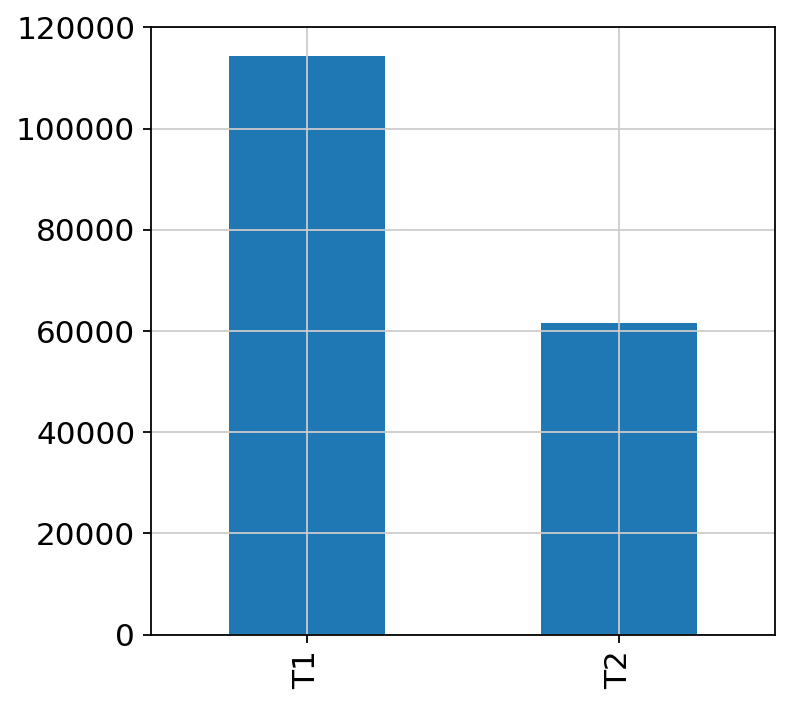

In [26]:
adata.obs['age_binned'].value_counts().plot.bar()
#adata.obs['compass_label'].value_counts()#.hist(bins = 200)

In [27]:
# make a label combining cell state, age, and cell vs nuclei
adata.obs['compass_label']=adata.obs['fine_grain'].astype(str)+'_'+adata.obs['age_binned'].astype(str)+'_'+adata.obs['cell_or_nuclei'].astype(str)

In [28]:
# how many compass_label categories are there
len(adata.obs['compass_label'].unique())

141

In [29]:
# how many cells in each compass_label category
adata.obs['compass_label'].value_counts()#.hist(bins = 50)

VentricularCardiomyocytesCompact_T2_Nuclei     10393
GreatVesselAdventitialFibroblasts_T1_Cell       9765
GreatVesselProgenitors_T1_Cell                  8658
MyocardialInterstitialFibroblasts_T1_Cell       8658
VentricularCardiomyocytesPRRX1pos_T2_Nuclei     8368
                                               ...  
ChromaffinCells_T2_Nuclei                         12
TCells_T1_Nuclei                                   9
SatelliteGlialCellProgenitors_T2_Nuclei            5
MastCells_T1_Nuclei                                4
NeuronProgenitors_T2_Nuclei                        3
Name: compass_label, Length: 141, dtype: int64

### Use Milo to make neighbourhoods (and then assign each neighbourhood to a 'compass label' group)

In [30]:
%%time
## Build KNN graph
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30)

## Assign cells to neighbourhoods
milo.make_nhoods(adata)

## Count cells from each sample in each nhood
milo.count_nhoods(adata, sample_col="fine_grain")

CPU times: user 33min 39s, sys: 9min 46s, total: 43min 25s
Wall time: 7min 48s


/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


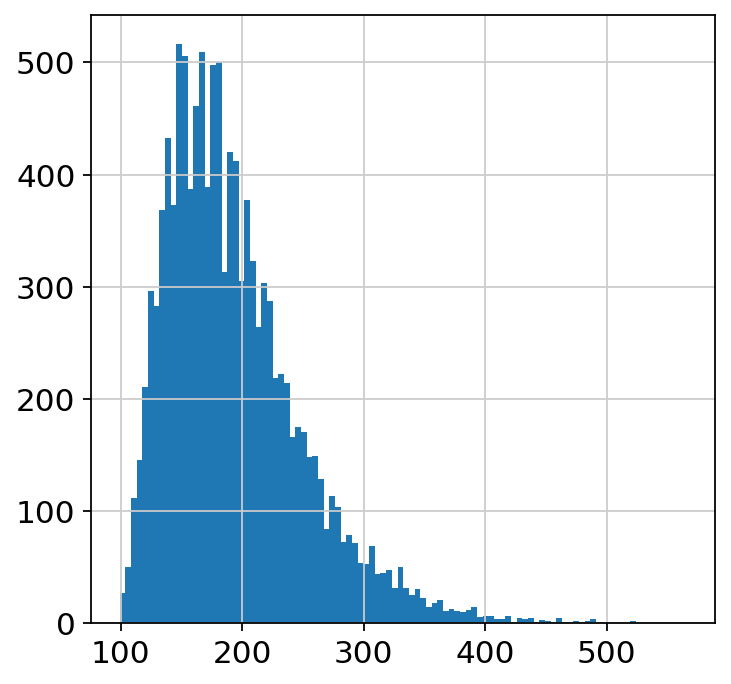

In [31]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [32]:
adata.obs["age_binned_continuous"] = adata.obs["age_binned"].cat.codes

In [33]:
milo.DA_nhoods(adata, design="~age_binned_continuous")

ValueError: Covariates cannot be unambiguously assigned to each sample -- each sample value should match a single covariate value

In [ ]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [ ]:
milopy.utils.build_nhood_graph(adata)

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.plot.plot_nhood_graph(adata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=1 ## Size of smallest dot
                       )

In [ ]:
milopy.utils.annotate_nhoods(adata, anno_col='fine_grain')


In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [ ]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.9, "nhood_annotation"] = "Mixed"

In [ ]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation",rotation=90,
             show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [ ]:
milopy.plot.plot_DA_beeswarm(adata)

In [15]:
%%time
milo.DA_nhoods(adata, design="~ age_binned")

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/rpy2/robjects/vectors.py:1008: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2236: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data.ravel("K"))
/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


CPU times: user 23.8 s, sys: 75.4 ms, total: 23.9 s
Wall time: 24 s


In [100]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha=0.2, min_size=2)

KeyError: 'logFC'

In [ ]:
milopy.utils.annotate_nhoods(adata, anno_col='celltype')

In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [ ]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

In [ ]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [86]:
%%time
# Make a .obs column with the attribution of each barcode to a neihbourhood (randomly assigning if a barcode is in >1 neighbourhood)
adata.obs["nhood_idx"] = dummy_to_categorical(adata.obsm["nhoods"], random_state=0)

CPU times: user 21.5 s, sys: 202 ms, total: 21.7 s
Wall time: 21.4 s


In [87]:
# Check how many barcodes are *not* assigned to any neighbourhood
(adata.obsm["nhoods"].sum(axis=1).A1 == 0).sum()

634

In [88]:
# Check how many neighbourhoods there are
len(adata.obs["nhood_idx"].unique())

12575

### Pseudobulk the neighbourhoods

In [91]:
# Pseudobulk use Ni's psudobulk function
pseudo_bulk = pseudo_bulk(adata,
                         groupby='the nh label')

In [92]:
print(pseudo_bulk.shape)
pseudo_bulk.head(3)

(36601, 8835)


,"AtrialCardiomyocytesCycling_T2_Nuclei,0","AtrialCardiomyocytesCycling_earlyT1_Cell,0","AtrialCardiomyocytesCycling_earlyT1_Cell,1","AtrialCardiomyocytesCycling_earlyT1_Cell,2","AtrialCardiomyocytesCycling_earlyT1_Cell,3","AtrialCardiomyocytesCycling_earlyT1_Cell,4","AtrialCardiomyocytesCycling_earlyT1_Nuclei,0","AtrialCardiomyocytesCycling_lateT1_Cell,0","AtrialCardiomyocytesCycling_lateT1_Cell,1","AtrialCardiomyocytesCycling_lateT1_Cell,2",...,"VentricularConductionSystemProximal_lateT1_Cell,4","VentricularConductionSystemProximal_lateT1_Cell,5","VentricularConductionSystemProximal_lateT1_Cell,6","VentricularConductionSystemProximal_lateT1_Cell,7","VentricularConductionSystemProximal_lateT1_Cell,8","VentricularConductionSystemProximal_lateT1_Cell,9","VentricularConductionSystemProximal_lateT1_Nuclei,0","VentricularConductionSystemProximal_lateT1_Nuclei,1","VentricularConductionSystemProximal_lateT1_Nuclei,2","VentricularConductionSystemProximal_lateT1_Nuclei,3"
MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Make metadata files needed

In [93]:
# make sample_names.tsv
pseudo_bulk.columns.to_frame().to_csv('/nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/sample_names.tsv', sep="\t", index=False, header=False)

# make genes.tsv
genes = pseudo_bulk.index.to_list()
genes = pd.DataFrame(genes)
genes.to_csv('/nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/genes.tsv', sep="\t", index = False, header=False)

# make expression.mtx
from scipy.io import mmwrite, mmread
from scipy.sparse import csr_matrix

# Count Matrix (log normed, all genes, not HVG subsetted)
sparce_mtx = csr_matrix(pseudo_bulk)
sparce_mtx = sparce_mtx
mmwrite('/nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/expression.mtx', sparce_mtx)

In [94]:
# Alter so it includes things you need (a reference e.g. barcode and a cell type e.g. in fine_grain)
adata.obs.to_csv('/nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/cell_metadata.csv')

# Run Compass

## bsub command

```
bsub \
-G teichlab \
-q hugemem \
-M600000 \
-R "select[mem>600000] rusage[mem=600000] span[hosts=1]" \
-n 30 \
-J allcells_batch_rand20 \
-o 'log/compass.%J.out' \
-e 'log/compass.%J.err' \
'/software/singularity-v3.6.4/bin/singularity run -B /nfs,/lustre -B ~/COMPASSResources:/usr/local/lib/python3.8/site-packages/compass/Resources /nfs/cellgeni/singularity/images/compass-v0.9.10.2-cplex-v20.10.sif compass --data-mtx /nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/expression.mtx /nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/genes.tsv /nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/sample_names.tsv --species homo_sapiens --precache --calc-metabolites --output-dir /nfs/team205/heart/compass/fetal_allcells_finegrain_agebin_cellnuc_batch_rand_20/out/ --detailed-perf --num-processes 30'
```